In [1]:
from collections import deque
import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

import modern_robotics as mr

import networkx as nx

from description.kinematics import JointPoint

from dataclasses import dataclass, field


@dataclass
class Link:
    name: str = ""
    joints: set[JointPoint] = field(default_factory=set)
    instance_counter: int = 0

    def __post_init__(self):
        Link.instance_counter += 1
        self.instance_counter = Link.instance_counter
        if self.name == "":
            self.name = "L" + str(self.instance_counter)

    def __hash__(self) -> int:
        return hash((self.name, *self.joints))

    def __eq__(self, __value: object) -> bool:
        self.joints == __value.joints


def get_pos(G: nx.Graph):
    pos = {}
    for node in G:
        pos[node] = [node.r[0], node.r[2]]

    return pos


def plot_link(L: Link, graph: nx.Graph):
    sub_g_l = graph.subgraph(L.joints)
    pos = get_pos(sub_g_l)
    nx.draw(
        sub_g_l,
        pos,
        node_color="b",
        linewidths=1.5,
        edge_color="b",
        node_shape="o",
        node_size=100,
        width=5,
        with_labels=False,
    )

In [3]:
# # https://cad.onshape.com/documents/52eb11422c701d811548a6f5/w/655758bb668dff773a0e7c1a/e/77ff7f84e82d8fb31fe9c30b
# # abs_ground = np.array([0.065, 0, -0.015])
# abs_ground = np.array([0.065, 0, -0.047])
# pos_toeA_joint = np.array([0.060, 0, -0.052]) - abs_ground
# pos_toeA_tarus_joint = np.array([-0.273, 0, -0.350]) - abs_ground
# pos_shin_joint = np.array([0.021, 0, -0.159]) - abs_ground
# pos_knee_spring = np.array([0.011, 0, -0.219]) - abs_ground
# pos_tarus_joint = np.array([-0.237, 0, -0.464]) - abs_ground
# pos_foot_joint = np.array([-0.080, 0, -0.753]) - abs_ground
# pos_molet_joint = np.array([-0.207, 0, -0.552]) - abs_ground
# pos_toeB_joint = np.array([-0.257, 0, -0.579]) - abs_ground
# pos_toeB_foot_joint = np.array([-0.118, 0, -0.776]) - abs_ground

# ground_joint = JointPoint(
#     r=np.zeros(3), w=np.array([0, 1, 0]), attach_ground=True, active=True
# )
# shin_joint = JointPoint(r=pos_shin_joint, w=np.array([0, 1, 0]), active=True)
# knee_spring = JointPoint(pos_knee_spring, w=np.array([0, 1, 0]), weld=True)
# tarus_joint = JointPoint(r=pos_tarus_joint, w=np.array([0, 1, 0]))
# foot_joint = JointPoint(
#     r=pos_foot_joint, w=np.array([0, 1, 0]), attach_endeffector=True
# )

# toeA_joint = JointPoint(r=pos_toeA_joint, w=np.array([0, 1, 0]))
# connect_toeA_tarus_joint = JointPoint(
#     r=pos_toeA_tarus_joint, w=np.array([0, 1, 0]), weld=True
# )

# molet_joint = JointPoint(r=pos_molet_joint, w=np.array([0, 1, 0]), active=True)
# toeB_joint = JointPoint(r=pos_toeB_joint, w=np.array([0, 1, 0]))
# toeB_foot_joint = JointPoint(
#     r=pos_toeB_foot_joint, w=np.array([0, 1, 0]), attach_endeffector=True
# )

# jts = [
#     ground_joint,
#     shin_joint,
#     knee_spring,
#     tarus_joint,
#     foot_joint,
#     toeA_joint,
#     connect_toeA_tarus_joint,
#     molet_joint,
#     toeB_joint,
#     toeB_foot_joint,
# ]

# graph = nx.Graph()
# for j in jts:
#     graph.add_node(j)
# main_branch = [ground_joint, shin_joint, knee_spring, tarus_joint, foot_joint]
# add_branch_1 = [
#     [ground_joint, shin_joint],
#     toeA_joint,
#     connect_toeA_tarus_joint,
#     [tarus_joint, foot_joint],
# ]
# add_branch_2 = [
#     [tarus_joint, foot_joint],
#     molet_joint,
#     toeB_joint,
#     toeB_foot_joint,
#     foot_joint,
# ]

# for id in range(len(main_branch) - 1):
#     graph.add_edge(main_branch[id], main_branch[id + 1], variable=False, active=False)
# for id in range(len(add_branch_1) - 1):
#     if isinstance(add_branch_1[id], list):
#         for j in add_branch_1[id]:
#             graph.add_edge(j, add_branch_1[id + 1], variable=False, active=False)
#     elif isinstance(add_branch_1[id + 1], list):
#         for j in add_branch_1[id + 1]:
#             graph.add_edge(j, add_branch_1[id], variable=False, active=False)
#     else:
#         graph.add_edge(
#             add_branch_1[id], add_branch_1[id + 1], variable=False, active=False
#         )
# for id in range(len(add_branch_2) - 1):
#     if isinstance(add_branch_2[id], list):
#         for j in add_branch_2[id]:
#             graph.add_edge(j, add_branch_2[id + 1], variable=False, active=False)
#     elif isinstance(add_branch_2[id + 1], list):
#         for j in add_branch_2[id + 1]:
#             graph.add_edge(j, add_branch_2[id], variable=False, active=False)
#     else:
#         graph.add_edge(
#             add_branch_2[id], add_branch_2[id + 1], variable=False, active=False
#         )

In [2]:
abs_ground = np.array([0.0, 0, 0.0])
main_J1 = np.array([1.011, 0, 1.075])
main_J2 = np.array([0.988, 0, 2.823])
main_J3 = np.array([2.396, 0, 3.461])
ground_2 = np.array([-1.602, 0, 0.0])
branch_1_J1 = np.array([-1.216, 0, 1.317])
branch_1_J2 = np.array([0.134, 0, 1.849])
branch_2_J1 = np.array([-0.808, 0, 2.862])
branch_2_J2 = np.array([0.849, 0, 3.814])

ground_joint = JointPoint(
    r=np.zeros(3), w=np.array([0, 1, 0]), attach_ground=True, active=True, name="Gabs"
)
JPm_J1 = JointPoint(r=main_J1, w=np.array([0, 1, 0]), active=True, name="J1m")
JPm_J2 = JointPoint(main_J2, w=np.array([0, 1, 0]), name="J2m", attach_endeffector=True)
JPm_J3 = JointPoint(
    r=main_J3, w=np.array([0, 1, 0]), name="J3m", attach_endeffector=True
)


ground_joint_2 = JointPoint(
    r=ground_2, w=np.array([0, 1, 0]), attach_ground=True, name="G2"
)
JPb1_J1 = JointPoint(r=branch_1_J1, w=np.array([0, 1, 0]), name="J1b1")
JPb1_J2 = JointPoint(r=branch_1_J2, w=np.array([0, 1, 0]), name="J2b1")

JPb2_J1 = JointPoint(r=branch_2_J1, w=np.array([0, 1, 0]), name="J1b2")
JPb2_J2 = JointPoint(
    r=branch_2_J2, w=np.array([0, 1, 0]), name="J2b2", attach_endeffector=True
)


jts = [
    ground_joint,
    JPm_J1,
    JPm_J2,
    JPm_J3,
    ground_joint_2,
    JPb1_J1,
    JPb1_J2,
    JPb2_J1,
    JPb2_J2,
]


In [3]:
graph = nx.Graph()
for j in jts:
    graph.add_node(j)
main_branch = [ground_joint, JPm_J1, JPm_J2, JPm_J3]
add_branch_1 = [
    ground_joint_2,
    JPb1_J1,
    JPb1_J2,
    [JPm_J1, JPm_J2]
]
add_branch_2 = [
    [JPb1_J1, JPb1_J2],
    JPb2_J1,
    JPb2_J2,
    [JPm_J2, JPm_J3]
]

for id in range(len(main_branch) - 1):
    graph.add_edge(main_branch[id], main_branch[id + 1], variable=False, active=False)
for id in range(len(add_branch_1) - 1):
    if isinstance(add_branch_1[id], list):
        for j in add_branch_1[id]:
            graph.add_edge(j, add_branch_1[id + 1], variable=False, active=False)
    elif isinstance(add_branch_1[id + 1], list):
        for j in add_branch_1[id + 1]:
            graph.add_edge(j, add_branch_1[id], variable=False, active=False)
    else:
        graph.add_edge(
            add_branch_1[id], add_branch_1[id + 1], variable=False, active=False
        )
for id in range(len(add_branch_2) - 1):
    if isinstance(add_branch_2[id], list):
        for j in add_branch_2[id]:
            graph.add_edge(j, add_branch_2[id + 1], variable=False, active=False)
    elif isinstance(add_branch_2[id + 1], list):
        for j in add_branch_2[id + 1]:
            graph.add_edge(j, add_branch_2[id], variable=False, active=False)
    else:
        graph.add_edge(
            add_branch_2[id], add_branch_2[id + 1], variable=False, active=False
        )

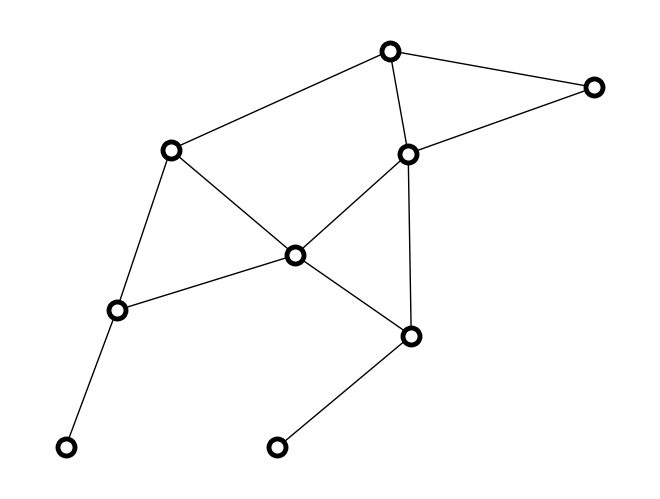

In [4]:
nx.draw(
    graph,
    get_pos(graph),
    node_color="w",
    linewidths=3.5,
    edgecolors="k",
    node_shape="o",
    node_size=150,
    with_labels=False,
)

In [5]:
R0 = 4.210
ground_joints = set(
    sorted(filter(lambda n: n.attach_ground, jts), key=lambda x: la.norm(x.r))
)
ee_joints = set(
        filter(lambda n: n.attach_endeffector, jts)
)

ground_link = Link("G", ground_joints)
ee_link = Link("EE", ee_joints)

In [6]:
stack_joints: deque[JointPoint] = deque(maxlen=len(graph.nodes()))

stack_joints += list([ground_joint])
j2link: dict[JointPoint, set[Link]] = {j: set() for j in graph.nodes()}
for j in ground_joints:
    j2link[j].add(ground_link)
for ee_j in ee_joints:
    j2link[ee_j].add(ee_link)

exped_j = set()
links: list[Link] = [ee_link, ground_link]

while stack_joints:
    curr_j = stack_joints.pop()
    print(curr_j.name)
    L = next(iter(j2link[curr_j]))
    exped_j.add(curr_j)
    L1 = graph.subgraph(L.joints)
    N = set(graph.neighbors(curr_j)) - L.joints
    nextN = {}
    lenNN = {}
    for n in N:
        nextN[n] = set(graph.neighbors(n))
        lenNN[n] = len(nextN[n] & L.joints)
        j2link[n]
    if len(L.joints) <= 2:
        L2 = Link(joints=(N | set([curr_j])))
        for j in L2.joints:
            j2link[j].add(L2)
    elif len(N) == 1:
        N = N.pop()
        if lenNN[n] == 1:
            L2 = Link(joints=set([N, curr_j]))
            for j in L2.joints:
                j2link[j].add(L2)
        else:
            L1.joints.add(n)
            j2link[n].add(L1)
            continue
    else:
        more_one_adj_L1 = set(filter(lambda n: lenNN[n] > 1, N))
        for n in more_one_adj_L1:
            L1.joints.add(n)
            j2link[n].add(L1)
        less_one_adj_L1 = N - more_one_adj_L1
        if len(less_one_adj_L1) > 1:
            N = less_one_adj_L1
            L2 = Link(joints= (N | set([curr_j])))
            for j in L2.joints:
                j2link[j].add(L2)
        else:
            N = less_one_adj_L1.pop()
            L2 = Link(joints=set([N, curr_j]))
            j2link[N].add(L2)
    links.append(L2)
    if isinstance(N, set):
        intersting_joints = set(filter(lambda n: len(j2link[n]) < 2, N))
        stack_joints += list(intersting_joints)
    else:
        intersting_joints = N if len(j2link[N]) < 2 else set()
        stack_joints.append(N)
    # tuple_j_l = list(map(lambda jl: (jl[0].name,) + tuple(l.name for l in jl[1]), j2link.items()))
    # # for jl in tuple_j_l:
    # #     print(jl)
    # print([j.name for j in stack_joints])
    stack_joints = deque(filter(lambda j: len(j2link[j]) < 2, stack_joints))
    # print([j.name for j in stack_joints])
    # print()

Gabs
J1m
J2b1
J1b1
J1b2


L6
G2 [-1.602  0.     0.   ]
J1b1 [-1.216  0.     1.317]


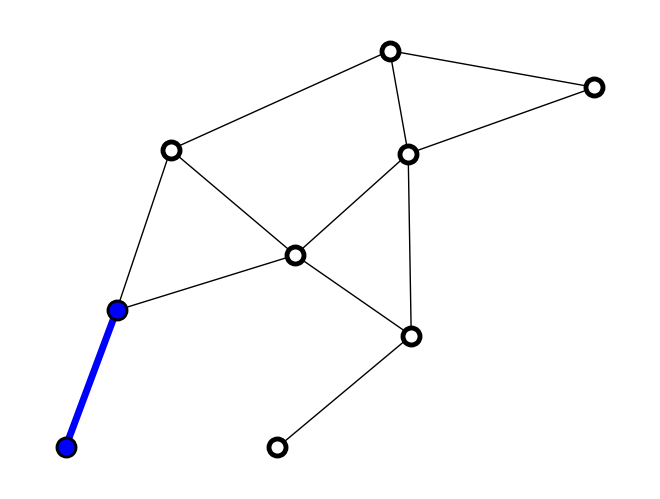

In [7]:
num = 5
nx.draw(
    graph,
    get_pos(graph),
    node_color="w",
    linewidths=3.5,
    edgecolors="k",
    node_shape="o",
    node_size=150,
    with_labels=False,
)
plot_link(links[num], graph)
print(links[num].name)
for j in links[num].joints:
    print(j.name, j.r)

In [10]:
links[num].joints

{JointPoint(r=array([-1.216,  0.   ,  1.317]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=False, attach_endeffector=False, name='J1b1', instance_counter=0),
 JointPoint(r=array([-1.602,  0.   ,  0.   ]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=True, attach_endeffector=False, name='G2', instance_counter=0)}

In [11]:
from itertools import combinations

kin_graph = nx.Graph()
for l in links:
    kin_graph.add_node(l.name, link=l)
pairs = combinations(links, 2)
# list_edges = list(map(lambda x: tuple(x), filter(lambda x: len(x[0].joints & x[1].joints)>0, pairs)))
list_edges = filter(lambda x: len(x[0].joints & x[1].joints) > 0, pairs)
list_edges = list(
    map(lambda x: x + tuple([(x[0].joints & x[1].joints).pop()]), list_edges)
)

In [12]:
for edge in list_edges:
    if edge[-1].active:
        w = 1
    else:
        w = 0.1
    if "EE" in (edge[0].name, edge[1].name):
        w = 0
    kin_graph.add_edge(edge[0].name, edge[1].name, joint=edge[-1], weight=w)

path_from_G = nx.shortest_path_length(kin_graph, source="EE")
for edge in kin_graph.edges():
    kin_graph[edge[0]][edge[1]]["weight"] += np.round(path_from_G[edge[1]] * 0.1, 3)
    kin_graph[edge[0]][edge[1]]["weight"] = np.round(kin_graph[edge[0]][edge[1]]["weight"], 3)

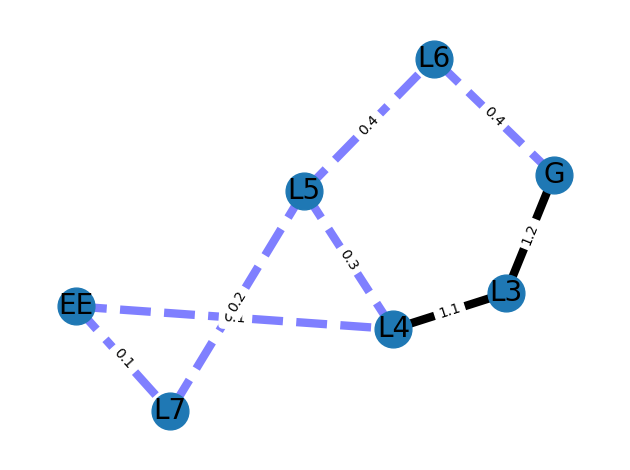

In [13]:
elarge = [(u, v) for (u, v, d) in kin_graph.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in kin_graph.edges(data=True) if d["weight"] <= 0.5]
pos = nx.spring_layout(kin_graph, seed=7)
nx.draw_networkx_nodes(kin_graph, pos, node_size=700)
nx.draw_networkx_edges(kin_graph, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    kin_graph, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)
nx.draw_networkx_labels(kin_graph, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(kin_graph, "weight")
nx.draw_networkx_edge_labels(kin_graph, pos, edge_labels)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
span_tree = nx.maximum_spanning_tree(kin_graph, algorithm="prim")

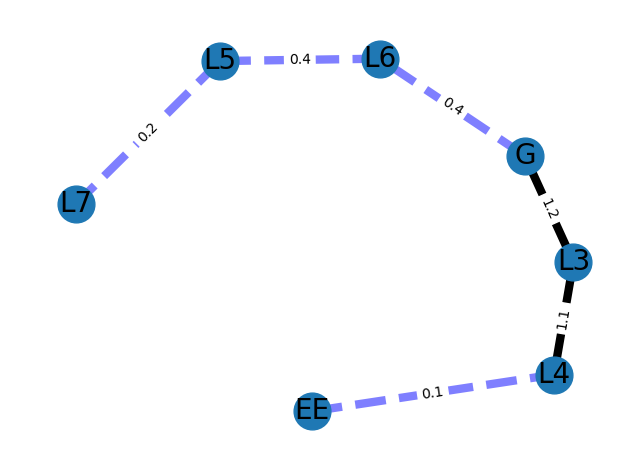

In [15]:
elarge = [(u, v) for (u, v, d) in span_tree.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in span_tree.edges(data=True) if d["weight"] <= 0.5]
pos = nx.spring_layout(span_tree, seed=7)
nx.draw_networkx_nodes(span_tree, pos, node_size=700)
nx.draw_networkx_edges(span_tree, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    span_tree, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)
nx.draw_networkx_labels(span_tree, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(span_tree, "weight")
nx.draw_networkx_edge_labels(span_tree, pos, edge_labels)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [16]:
main_branch = nx.shortest_path(span_tree, ground_link.name, ee_link.name)


kin_graph.nodes()["G"]["frame"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
kin_graph.nodes()["G"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
kin_graph.nodes()["G"]["H_w_l"] = mr.RpToTrans(np.eye(3), np.zeros(3))
kin_graph.nodes()["EE"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))

j2edge_main = {
    data[2]["joint"]: set((data[0], data[1])) for data in span_tree.edges(data=True)
}

costaints = []


def get_next_link(j, p_l):
    return (j2edge_main[j] - set([p_l])).pop()


ez = np.array([0, 0, 1, 0])


def define_link_frames(G, init_link = "G", in_joint = None):
    
    data_prev_link = G.nodes()[init_link]
    link = get_next_link(in_joint, init_link)

    G.nodes()[link]["in"] = (in_joint, init_link)
    sorted_out_jj = sorted(
        list(
            G.nodes()[link]["link"].joints & set(j2edge_main.keys()) - set([in_joint])
        ),
        key=lambda x: la.norm(x.r - in_joint.r),
        reverse=True,
    )

    H_w_L1 = data_prev_link["H_w_l"]
    if sorted_out_jj:
        if link in main_branch:
            i = np.argwhere(np.array(main_branch) == link).squeeze()
            G.nodes()[link]["m_out"] = (
                span_tree[main_branch[i]][main_branch[i + 1]]["joint"],
                main_branch[i + 1],
            )
        else:
            G.nodes()[link]["m_out"] = (
                sorted_out_jj[0],
                get_next_link(sorted_out_jj[0], link),
            )
        G.nodes()[link]["out"] = {j: get_next_link(j, link) for j in sorted_out_jj}
        ee_jj = G.nodes()[link]["m_out"][0].r
        v_w = G.nodes()[link]["m_out"][0].r - in_joint.r
    else:
        if link == "EE":
            ee_jj = graph.nodes() - set(
                map(lambda x: x[2]["joint"], kin_graph.edges(data=True))
            )
        else:
            ee_jj = (graph.nodes() - set(j2edge_main.keys())) & G.nodes()[link][
                "link"
            ].joints
        if ee_jj:
            # G.nodes()[link]["out"] = {j for j in ee_jj}
            ee_jj = sorted(
                list(ee_jj),
                key=lambda x: la.norm(x.r - in_joint.r),
                reverse=True,
            )
            G.nodes()[link]["m_out"] = (ee_jj[0],)
            ee_jj = ee_jj[0].r
            v_w = ee_jj - in_joint.r
        else:
            ee_jj = in_joint.r
            v_w = np.array([0, 0, 1])
    ez_l_w = H_w_L1 @ ez
    angle = np.arccos(np.inner(ez_l_w[:3], v_w) / la.norm(v_w) / la.norm(ez_l_w[:3]))
    axis = mr.VecToso3(ez_l_w[:3]) @ v_w
    axis /= la.norm(axis)

    pos = mr.TransInv(H_w_L1) @ np.array([*in_joint.r.tolist(), 1])
    pos = np.round(pos, 15)
    rot = R.from_rotvec(axis * angle)
    H_w_L2 = H_w_L1 @ mr.RpToTrans(rot.as_matrix(), pos[:3])
    G.nodes()[link]["H_w_l"] = H_w_L2
    G.nodes()[link]["frame"] = (pos[:3], rot.as_quat())
    G.nodes()[link]["frame_geom"] = (
        ((mr.TransInv(H_w_L2) @ np.array([*ee_jj.tolist(), 1])) / 2)[:3],
        np.array([0, 0, 0, 1]),
    )
    print(link)
    print(G.nodes()[link].get("in", {}))
    print(G.nodes()[link].get("out", {}))
    print(G.nodes()[link].get("m_out", {}))
    if link == "EE":
        return
    if G.nodes()[link].get("out", {}):
        for jj_out in G.nodes()[link]["out"]:
            if jj_out in j2edge_main.keys():
                define_link_frames(G, link, jj_out)
    return

In [17]:
main_branch = nx.shortest_path(span_tree, ground_link.name, ee_link.name)


kin_graph.nodes()["G"]["frame"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
kin_graph.nodes()["G"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
kin_graph.nodes()["G"]["H_w_l"] = mr.RpToTrans(np.eye(3), np.zeros(3))
kin_graph.nodes()["EE"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))

j2edge_main = {
    data[2]["joint"]: set((data[0], data[1])) for data in span_tree.edges(data=True)
}

costaints = []


def get_next_link(j, p_l):
    return (j2edge_main[j] - set([p_l])).pop()


ez = np.array([0, 0, 1, 0])




In [18]:
kin_graph.nodes()["G"]["frame"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
kin_graph.nodes()["G"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
kin_graph.nodes()["G"]["H_w_l"] = mr.RpToTrans(np.eye(3), np.zeros(3))
kin_graph.nodes()["EE"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
kin_graph.nodes()["G"]["m_out"] = (
    span_tree[main_branch[0]][main_branch[1]]["joint"],
    main_branch[1]
)
kin_graph.nodes()["G"]["out"] = {
    span_tree[main_branch[0]][main_branch[1]]["joint"]: main_branch[1],
    ground_joint_2 : get_next_link(ground_joint_2, "G")
}

In [23]:
define_link_frames(kin_graph, "G", ground_joint_2)

L3
(JointPoint(r=array([0., 0., 0.]), w=array([0, 1, 0]), weld=False, active=True, attach_ground=True, attach_endeffector=False, name='Gabs', instance_counter=0), 'G')
{JointPoint(r=array([1.011, 0.   , 1.075]), w=array([0, 1, 0]), weld=False, active=True, attach_ground=False, attach_endeffector=False, name='J1m', instance_counter=0): 'L4'}
(JointPoint(r=array([1.011, 0.   , 1.075]), w=array([0, 1, 0]), weld=False, active=True, attach_ground=False, attach_endeffector=False, name='J1m', instance_counter=0), 'L4')
L4
(JointPoint(r=array([1.011, 0.   , 1.075]), w=array([0, 1, 0]), weld=False, active=True, attach_ground=False, attach_endeffector=False, name='J1m', instance_counter=0), 'L3')
{JointPoint(r=array([0.988, 0.   , 2.823]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=False, attach_endeffector=True, name='J2m', instance_counter=0): 'EE'}
(JointPoint(r=array([0.988, 0.   , 2.823]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=False, attach_endeffector

In [24]:
(graph.nodes() - set(j2edge_main.keys())) & kin_graph.nodes()["L7"]["link"].joints

{JointPoint(r=array([0.849, 0.   , 3.814]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=False, attach_endeffector=True, name='J2b2', instance_counter=0)}

In [25]:
for k, v in j2edge_main.items():
    print(k.name, v)

J2m {'EE', 'L4'}
Gabs {'L3', 'G'}
G2 {'L6', 'G'}
J1m {'L3', 'L4'}
J1b1 {'L6', 'L5'}
J1b2 {'L7', 'L5'}


EE (array([-0.        ,  0.        ,  1.74815131]), array([0.        , 0.54739804, 0.        , 0.83687239]))
G (array([0, 0, 0]), array([0, 0, 0, 1]))
L3 (array([0., 0., 0.]), array([0.        , 0.36847078, 0.        , 0.92963933]))
L4 (array([-0.        ,  0.        ,  1.47571881]), array([ 0.        , -0.37457846,  0.        ,  0.92719522]))
L5 (array([0.        , 0.        , 1.37240118]), array([ 0.        , -0.01346057,  0.        ,  0.9999094 ]))
L6 (array([-1.602,  0.   ,  0.   ]), array([0.        , 0.14207052, 0.        , 0.98985654]))
L7 (array([-9.00000000e-15,  0.00000000e+00,  1.59796402e+00]), array([0.        , 0.38532957, 0.        , 0.92277902]))


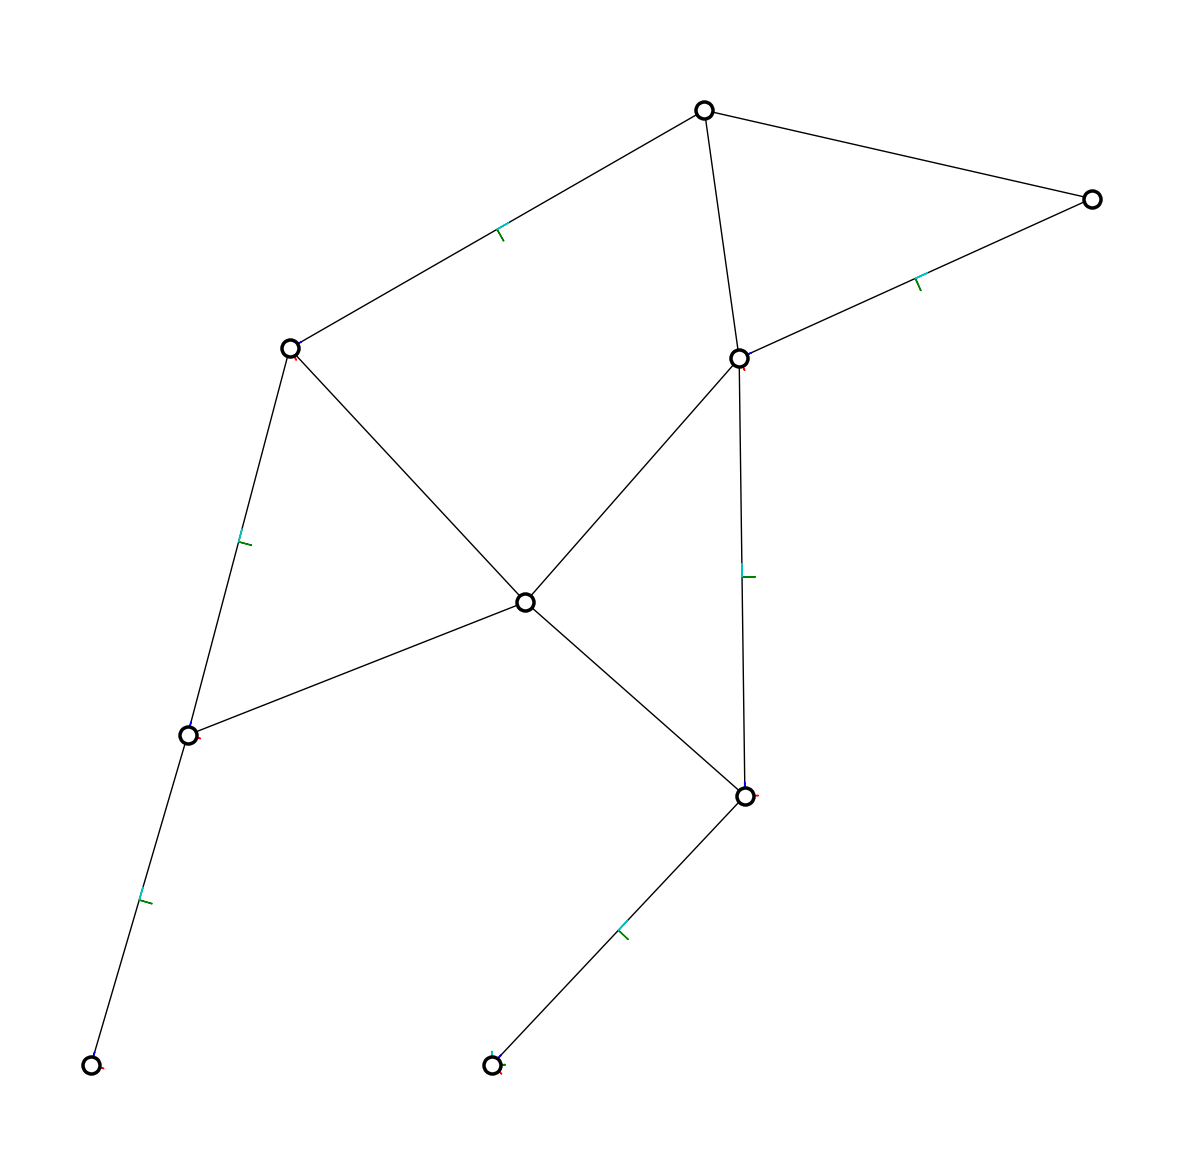

In [26]:
ex = np.array([1, 0, 0, 0])
ez = np.array([0, 0, 1, 0])
p = np.array([0, 0, 0, 1])
H = np.eye(4)
plt.figure(figsize=(15, 15))
plt.axis("equal")
nx.draw(
    graph,
    get_pos(graph),
    node_color="w",
    linewidths=2.5,
    edgecolors="k",
    node_shape="o",
    node_size=150,
    with_labels=False,
)
for name in kin_graph.nodes():
    data = kin_graph.nodes(data=True)[name]
    frame = data.get("frame", np.zeros(3))
    geom_l = data.get("frame_geom", np.zeros(3))
    H_w_l = data.get("H_w_l", np.eye(4))
    print(name, frame)
    if frame:
        Rmatr = R.from_quat(frame[1]).as_matrix()
        H = H_w_l  # H @ np.r_[np.c_[Rmatr, frame[0]], np.array([[0,0,0,1]])]
        ex_l = H @ ex
        ez_l = H @ ez
        p_l = H @ p
        # print(H)

        ex_g_l = H @ mr.RpToTrans(R.from_quat(geom_l[1]).as_matrix(), geom_l[0]) @ ex
        ez_g_l = H @ mr.RpToTrans(R.from_quat(geom_l[1]).as_matrix(), geom_l[0]) @ ez
        p_g_l = H @ mr.RpToTrans(R.from_quat(geom_l[1]).as_matrix(), geom_l[0]) @ p

        plt.arrow(p_l[0], p_l[2], ex_l[0] * 0.05, ex_l[2] * 0.05, color="r")
        plt.arrow(p_l[0], p_l[2], ez_l[0] * 0.05, ez_l[2] * 0.05, color="b")
        plt.arrow(p_g_l[0], p_g_l[2], ex_g_l[0] * 0.05, ex_g_l[2] * 0.05, color="g")
        plt.arrow(p_g_l[0], p_g_l[2], ez_g_l[0] * 0.05, ez_g_l[2] * 0.05, color="c")
plt.show()

In [27]:
def calculate_inertia(length):
    Ixx = 1 / 12 * 1 * (0.001**2 * length**2)
    Iyy = 1 / 12 * 1 * (0.001**2 * length**2)
    Izz = 1 / 12 * 1 * (0.001**2 * 0.001**2)
    return {"ixx": Ixx, "ixy": 0, "ixz": 0, "iyy": Iyy, "iyz": 0, "izz": Izz}


import odio_urdf as urdf

mechanism = urdf.Robot()

urdf_elements = []
for link in kin_graph.nodes():
    data_link = kin_graph.nodes()[link]
    geom_frame = data_link["frame_geom"]
    origin = [*geom_frame[0].tolist(), *R.from_quat(geom_frame[1]).as_euler("xyz")]
    # print(data_link)
    if link in ("EE", "G"):
        length = 0.1
    else:
        length = la.norm(data_link["m_out"][0].r - data_link["in"][0].r)
    inertia = calculate_inertia(length)
    urdf_link = urdf.Link(
        urdf.Inertial(
            urdf.Origin(
                xyz=geom_frame[0].tolist(),
                rpy=R.from_quat(geom_frame[1]).as_euler("xyz").tolist(),
            ),
            urdf.Mass(1),
            urdf.Inertia(**inertia),
        ),
        urdf.Visual(
            urdf.Origin(
                xyz=geom_frame[0].tolist(),
                rpy=R.from_quat(geom_frame[1]).as_euler("xyz").tolist(),
            ),
            urdf.Geometry(urdf.Box([0.1, 0.1, length])),
            urdf.Material("Grey"),
        ),
        urdf.Collision(
            urdf.Origin(
                xyz=geom_frame[0].tolist(),
                rpy=R.from_quat(geom_frame[1]).as_euler("xyz").tolist(),
            ),
            urdf.Geometry(urdf.Box([0.1, 0.1, length])),
            urdf.Material("Grey"),
        ),
        name=link,
    )
    urdf_elements.append(urdf_link)

    if data_link.get("out", {}):
        for out in data_link["out"].items():
            data_child_link = kin_graph.nodes()[out[1]]
            frame = data_child_link["frame"]
            urdf_elements.append(
                urdf.Joint(
                    urdf.Parent(link=link),
                    urdf.Child(link=out[1]),
                    urdf.Origin(
                        xyz=frame[0].tolist(),
                        rpy=R.from_quat(frame[1]).as_euler("xyz").tolist(),
                    ),
                    urdf.Axis(out[0].w.tolist()),
                    urdf.Limit(lower=-np.pi, upper=np.pi, effort=2, velocity=10),
                    urdf.Dynamics(damping=0.05),
                    name=out[0].name,
                    type="revolute",
                )
            )

my_robot = urdf.Robot(*urdf_elements)
with open("test.urdf", "w") as f:
    f.write(my_robot.urdf())
# for joint

In [31]:
kin_graph.edges() - span_tree.edges()
for edge in kin_graph.edges() - span_tree.edges():
    print(edge[0], edge[1], kin_graph[edge[0]][edge[1]]["joint"])
    

EE L7 JointPoint(r=array([0.849, 0.   , 3.814]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=False, attach_endeffector=True, name='J2b2', instance_counter=0)
L4 L5 JointPoint(r=array([0.134, 0.   , 1.849]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=False, attach_endeffector=False, name='J2b1', instance_counter=0)


In [2]:
from copy import deepcopy
import trimesh

J1 = [1.087, 0, 1.435]
J2 = [5.459, 0, 2.501]
end = [5.5, 0, 2.6]

JP = [J1, J2, end]
verteces = []
for v in JP:
    v2 = deepcopy(v)
    v[1] = 0.1
    v2[1] - 1
    verteces.append(v)
    verteces.append(v2)